In [1]:
# Social Media Sentiment Analysis - Batch Layer Implementation

## Setup and Dependencies
!pip install pyspark pymongo transformers torch nltk pymongo[srv]
!pip install textblob vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode, split, when, lit
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, IntegerType, FloatType, TimestampType
import pymongo
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from nltk.tokenize import word_tokenize
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
## Google Drive Integration
# Mount Google Drive to save processed data and models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set project directory
PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis'
os.makedirs(PROJECT_DIR, exist_ok=True)

In [6]:
## Initialize Spark Session
spark = SparkSession.builder \
    .appName("SentimentAnalysisBatchLayer") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

Spark version: 3.5.5


In [7]:
## Connect to MongoDB
from google.colab import userdata
# Get credentials secreat keys
username = userdata.get('mongodb_username')
password = userdata.get('mongodb_pw')
cluster_url = "cluster0.8ad48r1.mongodb.net"
MONGO_CONNECTION_STRING = f"mongodb+srv://{username}:{password}@{cluster_url}/?retryWrites=true&w=majority&appName=Cluster0"

def connect_to_mongodb():
    """Connect to MongoDB and return the database client."""
    try:
        client = pymongo.MongoClient(MONGO_CONNECTION_STRING)
        print("Connected to MongoDB successfully!")
        return client
    except Exception as e:
        print(f"Failed to connect to MongoDB: {e}")
        return None

mongo_client = connect_to_mongodb()
db = mongo_client["social_media_analytics"] if mongo_client else None

Connected to MongoDB successfully!


In [8]:
db.list_collection_names()

['mastodon_tags_data',
 'youtube_unique_tag',
 'mastodon_unique_tag',
 'youtube_tags_data',
 'youtube_sentiment_collection',
 'mastodon_sentiment_data']

In [9]:
def load_data_from_mongodb():
    """Load data from MongoDB collections into PySpark DataFrames."""

    # Create schema for Mastodon data
    mastodon_schema = StructType([
        StructField("tag", StringType(), True),
        StructField("text", StringType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("post_url", StringType(), True)
    ])

    # Create schema for YouTube data
    youtube_schema = StructType([
        StructField("tag", StringType(), True),
        StructField("text", StringType(), True),
        StructField("published_at", StringType(), True),
        StructField("video_id", StringType(), True),
        StructField("video_title", StringType(), True)
    ])

    # Load Mastodon data
    mastodon_data = []
    if db is not None:  # Changed from 'if db' to 'if db is not None'
        for doc in db.mastodon_sentiment_data.find():
            mastodon_data.append(doc)

    # Load YouTube data
    youtube_data = []
    if db is not None:  # Changed from 'if db' to 'if db is not None'
        for doc in db.youtube_sentiment_collection.find():
            youtube_data.append(doc)

    # Create PySpark DataFrames
    mastodon_df = spark.createDataFrame(mastodon_data, schema=mastodon_schema) if mastodon_data else None
    youtube_df = spark.createDataFrame(youtube_data, schema=youtube_schema) if youtube_data else None

    return mastodon_df, youtube_df

In [10]:
# Load the data
mastodon_df, youtube_df = load_data_from_mongodb()

if mastodon_df:
    print(f"Loaded {mastodon_df.count()} Mastodon posts")
    mastodon_df.printSchema()
    mastodon_df.show(5, truncate=True)

if youtube_df:
    print(f"Loaded {youtube_df.count()} YouTube comments")
    youtube_df.printSchema()
    youtube_df.show(5, truncate=True)

Loaded 132 Mastodon posts
root
 |-- tag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- post_url: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                 tag|                text|          created_at|            post_url|
+--------------------+--------------------+--------------------+--------------------+
|#complaintsongsor...|performance fanta...| 2025-04-16 19:26:45|https://lounge.to...|
|#complaintsongsor...|read totally hear...| 2025-04-17 01:49:29|https://lounge.to...|
|  #throwbackthursday|   ist durchoxidiert| 2025-04-17 16:21:47|https://chaos.soc...|
|  #throwbackthursday|eiexplosion minko...| 2025-04-17 16:23:22|https://chaos.soc...|
|  #throwbackthursday|youve read book t...|2025-04-17 16:27:...|https://mastodon....|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

Loaded 230 Yo

In [11]:
## Data Preprocessing
def preprocess_mastodon_data(df):
    """Preprocess Mastodon data."""
    if df is None:
        return None

    # Convert timestamp to date format
    df = df.withColumn("date", col("created_at").cast("date"))

    # Clean content: Remove HTML tags, URLs, etc.
    clean_content_udf = udf(lambda x: clean_text(x), StringType())
    df = df.withColumn("clean_content", clean_content_udf(col("text")))

    # Filter out empty content
    df = df.filter(col("clean_content").isNotNull() & (col("clean_content") != ""))

    return df

def preprocess_youtube_data(df):
    """Preprocess YouTube data."""
    if df is None:
        return None

    # Convert publishedAt to date format
    df = df.withColumn("date", col("published_at").cast("date"))

    # Clean comment text
    clean_comment_udf = udf(lambda x: clean_text(x), StringType())
    df = df.withColumn("clean_commentText", clean_comment_udf(col("text")))

    # Filter out empty comments
    df = df.filter(col("clean_commentText").isNotNull() & (col("clean_commentText") != ""))

    return df

def clean_text(text):
    """Clean text by removing unwanted characters, HTML tags, links, etc."""
    if not text:
        return None

    import re
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtag symbols but keep the text
    text = re.sub(r'#', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text if text else None

In [12]:
# Process the data
processed_mastodon_df = preprocess_mastodon_data(mastodon_df)
processed_youtube_df = preprocess_youtube_data(youtube_df)

In [13]:
processed_youtube_df.show(5)

+----------------+--------------------+--------------------+-----------+--------------------+----------+--------------------+
|             tag|                text|        published_at|   video_id|         video_title|      date|   clean_commentText|
+----------------+--------------------+--------------------+-----------+--------------------+----------+--------------------+
|hololive english|yagoo company bur...|2025-04-17T03:35:03Z|bthtAJiE3iE|Hololive&#39;s Ga...|2025-04-17|yagoo company bur...|
|hololive english|      crazy hololive|2025-04-17T02:30:42Z|bthtAJiE3iE|Hololive&#39;s Ga...|2025-04-17|      crazy hololive|
|hololive english|hololive dont kno...|2025-04-17T01:31:43Z|bthtAJiE3iE|Hololive&#39;s Ga...|2025-04-17|hololive dont kno...|
|hololive english|super upset guras...|2025-04-17T00:35:41Z|bthtAJiE3iE|Hololive&#39;s Ga...|2025-04-17|super upset guras...|
|hololive english|farewell gura alw...|2025-04-17T00:02:35Z|bthtAJiE3iE|Hololive&#39;s Ga...|2025-04-17|farewell gura 

In [14]:
if processed_mastodon_df:
    print("Processed Mastodon data:")
    processed_mastodon_df.select("tag", "clean_content", "date").show(5, truncate=True)

if processed_youtube_df:
    print("Processed YouTube data:")
    processed_youtube_df.select("tag", "clean_commentText", "date").show(5, truncate=True)


Processed Mastodon data:
+--------------------+--------------------+----------+
|                 tag|       clean_content|      date|
+--------------------+--------------------+----------+
|#complaintsongsor...|performance fanta...|2025-04-16|
|#complaintsongsor...|read totally hear...|2025-04-17|
|  #throwbackthursday|   ist durchoxidiert|2025-04-17|
|  #throwbackthursday|eiexplosion minko...|2025-04-17|
|  #throwbackthursday|youve read book t...|2025-04-17|
+--------------------+--------------------+----------+
only showing top 5 rows

Processed YouTube data:
+----------------+--------------------+----------+
|             tag|   clean_commentText|      date|
+----------------+--------------------+----------+
|hololive english|yagoo company bur...|2025-04-17|
|hololive english|      crazy hololive|2025-04-17|
|hololive english|hololive dont kno...|2025-04-17|
|hololive english|super upset guras...|2025-04-17|
|hololive english|farewell gura alw...|2025-04-17|
+----------------+-----

In [17]:
## Sentiment Analysis

# Option 3: Using HuggingFace Transformers for advanced sentiment analysis
def load_sentiment_model():
    """Load a pre-trained sentiment analysis model."""
    model_name = "cardiffnlp/twitter-roberta-base-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    return tokenizer, model

tokenizer, model = load_sentiment_model()

def analyze_sentiment_transformers(text, tokenizer=tokenizer, model=model, max_length=512):
    """Analyze sentiment using Transformers."""
    if not text:
        return None

    # Truncate text if needed
    if len(text) > max_length * 4:  # rough character estimate
        text = text[:max_length * 4]

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)

    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_id = torch.argmax(scores).item()

    # Map sentiment ID to label (specific to the model)
    id2label = {0: "negative", 1: "neutral", 2: "positive"}
    sentiment = id2label[sentiment_id]

    return sentiment


In [18]:
# Register UDFs for sentiment analysis
# sentiment_textblob_udf = udf(analyze_sentiment_textblob, StringType())
# sentiment_vader_udf = udf(analyze_sentiment_vader, StringType())
sentiment_transformers_udf = udf(analyze_sentiment_transformers, StringType())

In [19]:
# Apply sentiment analysis to Mastodon data
if processed_mastodon_df:
    mastodon_with_sentiment = processed_mastodon_df.withColumn(
        "sentiment", sentiment_transformers_udf(col("clean_content"))
    )

    print("Mastodon data with sentiment:")
    mastodon_with_sentiment.select("clean_content", "sentiment").show(5, truncate=True)

# Apply sentiment analysis to YouTube data
if processed_youtube_df:
    youtube_with_sentiment = processed_youtube_df.withColumn(
        "sentiment", sentiment_transformers_udf(col("clean_commentText"))
    )

    print("YouTube data with sentiment:")
    youtube_with_sentiment.select("clean_commentText", "sentiment").show(5, truncate=True)

Mastodon data with sentiment:
+--------------------+---------+
|       clean_content|sentiment|
+--------------------+---------+
|performance fanta...| positive|
|read totally hear...|  neutral|
|   ist durchoxidiert|  neutral|
|eiexplosion minko...|  neutral|
|youve read book t...|  neutral|
+--------------------+---------+
only showing top 5 rows

YouTube data with sentiment:
+--------------------+---------+
|   clean_commentText|sentiment|
+--------------------+---------+
|yagoo company bur...| negative|
|      crazy hololive|  neutral|
|hololive dont kno...|  neutral|
|super upset guras...| negative|
|farewell gura alw...| positive|
+--------------------+---------+
only showing top 5 rows



In [38]:
## Aggregate and Analyze Results
from pyspark.sql.functions import col, explode, to_date
import pandas as pd

def analyze_sentiment_by_platform(mastodon_df=None, youtube_df=None):
    """Analyze sentiment distribution by platform, including platform type."""
    results = []

    # Mastodon sentiment distribution
    if mastodon_df is not None:
        print("Processing Mastodon sentiment distribution...")
        mastodon_sentiment_counts = mastodon_df.groupBy("sentiment").count().toPandas()
        if not mastodon_sentiment_counts.empty:
            mastodon_sentiment_counts['platform'] = 'mastodon'
            results.extend(mastodon_sentiment_counts[['platform', 'sentiment', 'count']].to_dict('records'))
        else:
            print("No Mastodon sentiment data found")
    else:
        print("Mastodon DataFrame is None")

    # YouTube sentiment distribution
    if youtube_df is not None:
        print("Processing YouTube sentiment distribution...")
        youtube_sentiment_counts = youtube_df.groupBy("sentiment").count().toPandas()
        if not youtube_sentiment_counts.empty:
            youtube_sentiment_counts['platform'] = 'youtube'
            results.extend(youtube_sentiment_counts[['platform', 'sentiment', 'count']].to_dict('records'))
        else:
            print("No YouTube sentiment data found")
    else:
        print("YouTube DataFrame is None")

    return results


def analyze_sentiment_over_time(mastodon_df=None, youtube_df=None):
    """Analyze sentiment trends over time, including platform type."""
    results = []

    # Mastodon sentiment over time
    if mastodon_df is not None:
        print("Processing Mastodon sentiment over time...")
        mastodon_df = mastodon_df.withColumn("date", to_date(col("created_at"))).withColumn("platform", lit("mastodon"))
        mastodon_time_trends = mastodon_df.groupBy("platform", "date", "sentiment").count().toPandas()
        if not mastodon_time_trends.empty:
            results.append(mastodon_time_trends)
        else:
            print("No Mastodon time trend data found")
    else:
        print("Mastodon DataFrame is None")

    # YouTube sentiment over time
    if youtube_df is not None:
        print("Processing YouTube sentiment over time...")
        youtube_df = youtube_df.withColumn("date", to_date(col("published_at"))).withColumn("platform", lit("youtube"))
        youtube_time_trends = youtube_df.groupBy("platform", "date", "sentiment").count().toPandas()
        if not youtube_time_trends.empty:
            results.append(youtube_time_trends)
        else:
            print("No YouTube time trend data found")
    else:
        print("YouTube DataFrame is None")

    # Combine results into a single DataFrame
    if results:
        return pd.concat(results, ignore_index=True)
    return pd.DataFrame()

def analyze_sentiment_by_tag(mastodon_df=None):
    """Analyze sentiment by tag (for Mastodon), including platform type."""
    if mastodon_df is None:
        print("Mastodon DataFrame is None")
        return None

    print("Processing Mastodon sentiment by tag...")
    # Add platform column
    mastodon_df = mastodon_df.withColumn("platform", lit("mastodon"))
    tag_sentiment = mastodon_df.groupBy("platform", "tag", "sentiment").count()

    # Get the most common tags
    top_tags = mastodon_df.groupBy("tag").count().orderBy(col("count").desc()).limit(20).toPandas()

    if not top_tags.empty:
        top_tag_list = top_tags["tag"].tolist()
        top_tag_sentiment = tag_sentiment.filter(col("tag").isin(top_tag_list)).toPandas()
        if not top_tag_sentiment.empty:
            return top_tag_sentiment
        else:
            print("No sentiment data for top tags")
            return None
    else:
        print("No tags found in Mastodon data")
        return None

In [39]:
# Run the analyses
platform_sentiment = analyze_sentiment_by_platform(mastodon_with_sentiment, youtube_with_sentiment)
time_sentiment = analyze_sentiment_over_time(mastodon_with_sentiment, youtube_with_sentiment)
tag_sentiment = analyze_sentiment_by_tag(mastodon_with_sentiment)

Processing Mastodon sentiment distribution...
Processing YouTube sentiment distribution...
Processing Mastodon sentiment over time...
Processing YouTube sentiment over time...
Processing Mastodon sentiment by tag...


In [42]:
## Visualize Results

def visualize_sentiment_distribution(platform_sentiment):
    """Visualize sentiment distribution by platform."""
    if not platform_sentiment:
        print("No platform sentiment data available.")
        return

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(platform_sentiment)

    plt.figure(figsize=(12, 6))

    platforms = df['platform'].unique()
    for i, platform in enumerate(platforms):
        platform_data = df[df['platform'] == platform]
        sentiments = platform_data['sentiment']
        counts = platform_data['count']

        plt.subplot(1, len(platforms), i+1)
        plt.bar(sentiments, counts, color=['blue', 'gray', 'green'])
        plt.title(f"{platform.capitalize()} Sentiment Distribution")
        plt.ylabel("Count")
        plt.xlabel("Sentiment")

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/sentiment_distribution.png")
    plt.show()

def visualize_sentiment_over_time(time_sentiment):
    """Visualize sentiment trends over time."""
    if time_sentiment.empty:
        print("No time sentiment data available.")
        return

    plt.figure(figsize=(14, 10))

    platforms = time_sentiment['platform'].unique()
    for i, platform in enumerate(platforms):
        platform_data = time_sentiment[time_sentiment['platform'] == platform]

        plt.subplot(len(platforms), 1, i+1)

        for sentiment in ['positive', 'neutral', 'negative']:
            sentiment_df = platform_data[platform_data['sentiment'] == sentiment]
            plt.plot(sentiment_df['date'], sentiment_df['count'],
                    marker='o', linestyle='-', label=sentiment)

        plt.title(f"{platform.capitalize()} Sentiment Over Time")
        plt.xlabel("Date")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/sentiment_time_trends.png")
    plt.show()

def visualize_tag_sentiment(tag_sentiment):
    """Visualize sentiment by tag."""
    if tag_sentiment is None or tag_sentiment.empty:
        print("No tag sentiment data available.")
        # Debug: Check tag column in mastodon_with_sentiment
        if 'mastodon_with_sentiment' in globals():
            print("Checking Mastodon tag column:")
            mastodon_with_sentiment.select("tag").show(5)
            print("Non-null tag count:", mastodon_with_sentiment.filter(col("tag").isNotNull()).count())
        return

    # Get top 10 tags by total count
    tag_totals = tag_sentiment.groupby('tag')['count'].sum().reset_index()
    top_tags = tag_totals.sort_values('count', ascending=False).head(10)['tag'].tolist()

    # Filter data for top tags
    filtered_data = tag_sentiment[tag_sentiment['tag'].isin(top_tags)]

    # Create a pivot table
    pivot_data = filtered_data.pivot_table(
        index='tag',
        columns='sentiment',
        values='count',
        aggfunc='sum'
    ).fillna(0)

    # Calculate percentages
    pivot_data_pct = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

    # Plot
    plt.figure(figsize=(14, 8))
    pivot_data_pct.plot(kind='barh', stacked=True,
                       color=['blue', 'gray', 'green'])
    plt.title('Sentiment Distribution by Top Tags (Mastodon)')
    plt.xlabel('Percentage')
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/tag_sentiment.png")
    plt.show()

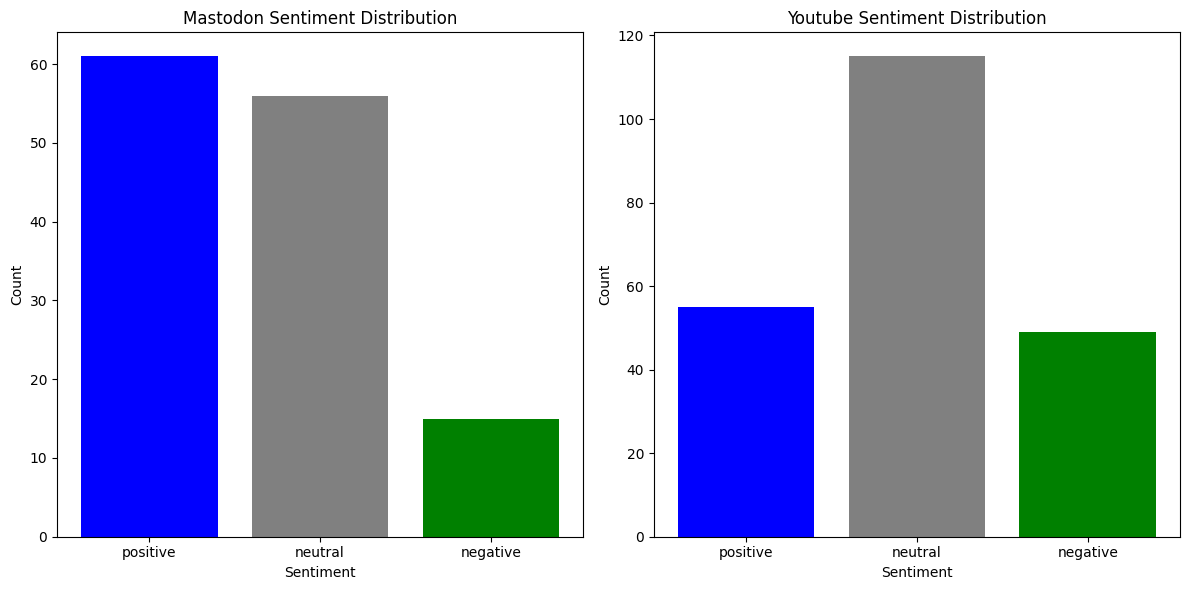

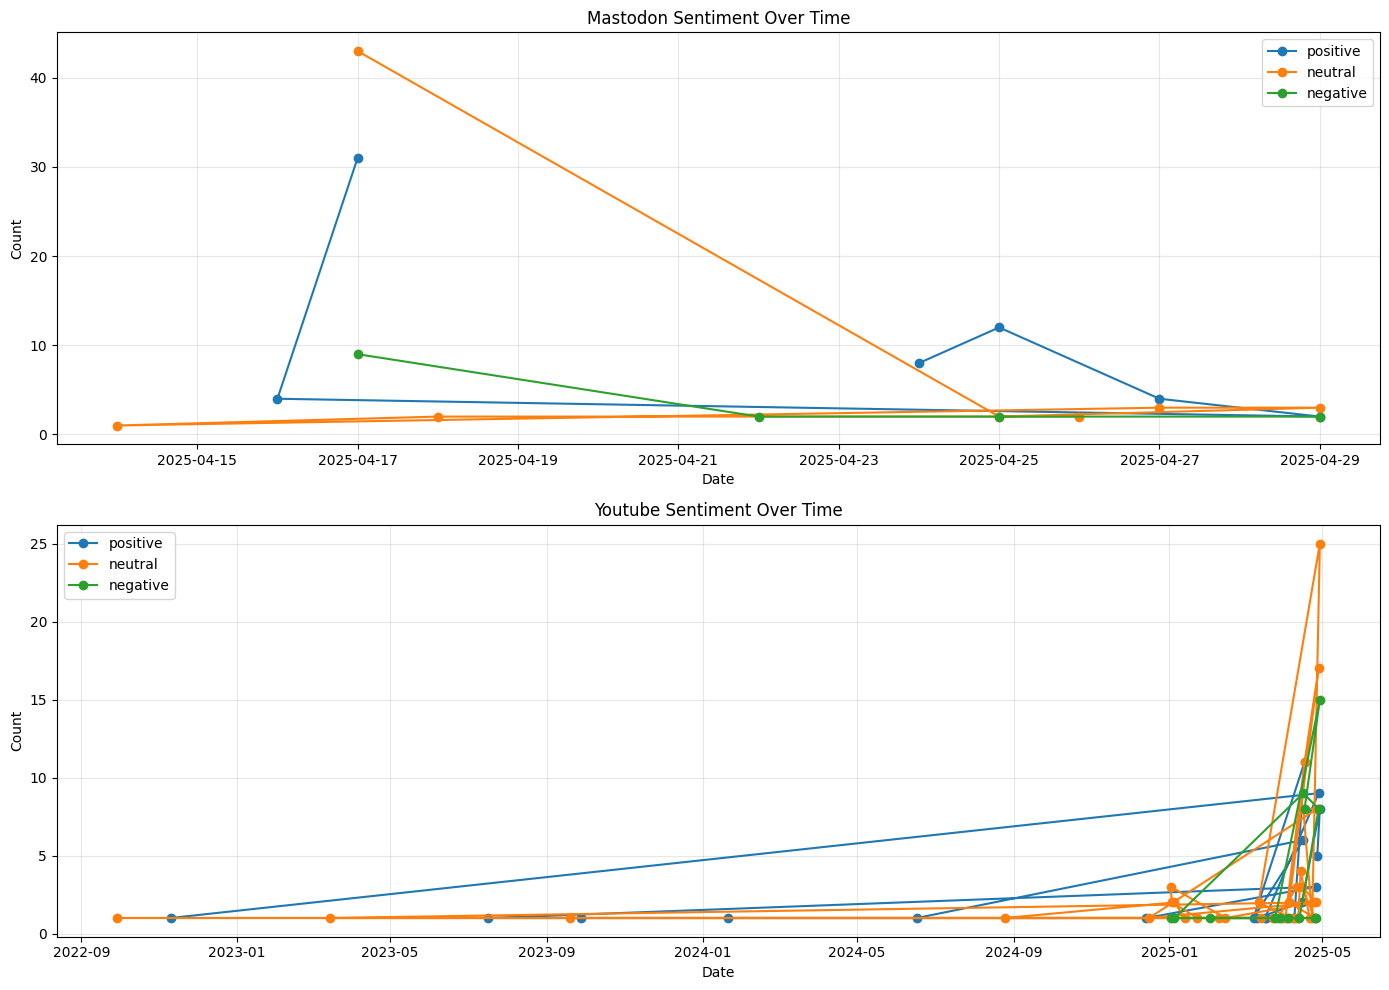

<Figure size 1400x800 with 0 Axes>

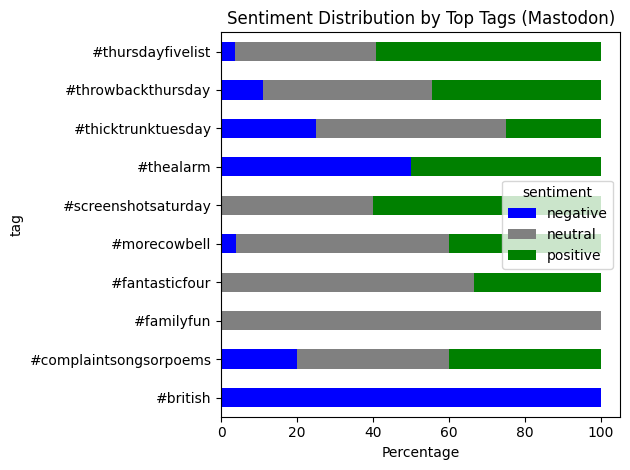

In [44]:
# Run the visualizations
if platform_sentiment:
    visualize_sentiment_distribution(platform_sentiment)

if not time_sentiment.empty:  # Fixed boolean check
    visualize_sentiment_over_time(time_sentiment)

if tag_sentiment is not None:
    visualize_tag_sentiment(tag_sentiment)

In [45]:
## Save Processed Data for Serving Layer
batch_platform_sentiment = db['batch_platform_sentiment']
batch_tag_sentiment = db['batch_tag_sentiment']

def save_to_mongodb():
    """Save processed data back to MongoDB for the serving layer."""
    if db is None:
        print("MongoDB connection not available. Cannot save results.")
        return

    try:
        # Save platform sentiment distribution
        if platform_sentiment:
            print("Saving platform sentiment:", platform_sentiment)
            db.batch_platform_sentiment.delete_many({})
            db.batch_platform_sentiment.insert_one({
                "timestamp": datetime.now(),
                "data": platform_sentiment
            })
            print("Saved platform sentiment distribution to MongoDB.")
        else:
            print("No platform sentiment data to save")


        # Save tag sentiment
        if tag_sentiment is not None and not tag_sentiment.empty:
            print("Saving tag sentiment:", tag_sentiment)
            tag_data = tag_sentiment.to_dict('records')
            db.batch_tag_sentiment.delete_many({})
            db.batch_tag_sentiment.insert_one({
                "timestamp": datetime.now(),
                "data": tag_data
            })
            print("Saved tag sentiment analysis to MongoDB.")
        else:
            print("No tag sentiment data to save")

    except Exception as e:
        print(f"Error saving to MongoDB: {str(e)}")


In [48]:
def save_to_csv():
    """Save processed data to CSV files."""
    # Validate PROJECT_DIR
    if not os.path.exists(PROJECT_DIR):
        print(f"PROJECT_DIR {PROJECT_DIR} does not exist. Creating it.")
        os.makedirs(PROJECT_DIR)
    if not os.access(PROJECT_DIR, os.W_OK):
        print(f"PROJECT_DIR {PROJECT_DIR} is not writable. Cannot save CSV files.")
        return

    # Save processed data with sentiment
    if 'mastodon_with_sentiment' in globals():
        mastodon_df = mastodon_with_sentiment.toPandas()
        print("Mastodon data sample:", mastodon_df.head())
        mastodon_df.to_csv(f"{PROJECT_DIR}/mastodon_with_sentiment.csv", index=False)
        print(f"Saved mastodon data to {PROJECT_DIR}/mastodon_with_sentiment.csv")
    else:
        print("mastodon_with_sentiment is not defined")

    if 'youtube_with_sentiment' in globals():
        youtube_df = youtube_with_sentiment.toPandas()
        print("YouTube data sample:", youtube_df.head())
        youtube_df.to_csv(f"{PROJECT_DIR}/youtube_with_sentiment.csv", index=False)
        print(f"Saved youtube data to {PROJECT_DIR}/youtube_with_sentiment.csv")
    else:
        print("youtube_with_sentiment is not defined")

    # Save platform sentiment
    if platform_sentiment:
        platform_df = pd.DataFrame(platform_sentiment)
        print("Platform sentiment sample:", platform_df.head())
        if not platform_df.empty:
            platform_df.to_csv(f"{PROJECT_DIR}/platform_sentiment.csv", index=False)
            print(f"Saved platform sentiment to {PROJECT_DIR}/platform_sentiment.csv")
        else:
            print("Platform sentiment DataFrame is empty")
    else:
        print("No platform sentiment data to save")

    # Save time sentiment
    if not time_sentiment.empty:
        print("Time sentiment sample:", time_sentiment.head())
        for platform in time_sentiment['platform'].unique():
            platform_df = time_sentiment[time_sentiment['platform'] == platform]
            platform_df.to_csv(f"{PROJECT_DIR}/{platform}_time_sentiment.csv", index=False)
            print(f"Saved {platform} time sentiment to {PROJECT_DIR}/{platform}_time_sentiment.csv")
    else:
        print("No time sentiment data to save")

    # Save tag sentiment
    if tag_sentiment is not None and not tag_sentiment.empty:
        print("Tag sentiment sample:", tag_sentiment.head())
        tag_sentiment.to_csv(f"{PROJECT_DIR}/tag_sentiment.csv", index=False)
        print(f"Saved tag sentiment to {PROJECT_DIR}/tag_sentiment.csv")
    else:
        print("No tag sentiment data to save")

In [49]:
# Save results
save_to_mongodb()
save_to_csv()

Saving platform sentiment: [{'platform': 'mastodon', 'sentiment': 'positive', 'count': 61}, {'platform': 'mastodon', 'sentiment': 'neutral', 'count': 56}, {'platform': 'mastodon', 'sentiment': 'negative', 'count': 15}, {'platform': 'youtube', 'sentiment': 'positive', 'count': 55}, {'platform': 'youtube', 'sentiment': 'neutral', 'count': 115}, {'platform': 'youtube', 'sentiment': 'negative', 'count': 49}]
Saved platform sentiment distribution to MongoDB.
Saving tag sentiment:     platform                     tag sentiment  count
0   mastodon            #morecowbell  positive     10
1   mastodon          #fantasticfour  positive      2
2   mastodon       #thursdayfivelist  negative      2
3   mastodon  #complaintsongsorpoems  positive      4
4   mastodon      #throwbackthursday   neutral      8
5   mastodon            #morecowbell   neutral     14
6   mastodon       #thursdayfivelist  positive     32
7   mastodon            #morecowbell  negative      1
8   mastodon          #fantasticfo

In [50]:
## Compare MapReduce vs. Spark Performance

# For comparison purposes, we'll implement a simple MapReduce-style function
def mapreduce_sentiment_analysis(data_list, sentiment_func):
    """
    Implement a simple MapReduce-style sentiment analysis.

    Parameters:
    data_list: List of dictionaries containing text data
    sentiment_func: Function to analyze sentiment

    Returns:
    Dictionary of sentiment counts
    """
    import time
    start_time = time.time()

    # Map phase - apply sentiment analysis to each text
    def mapper(text):
        return sentiment_func(text)

    mapped_data = []
    for item in data_list:
        text = item.get('clean_content') or item.get('clean_commentText')
        if text:
            sentiment = mapper(text)
            mapped_data.append((sentiment, 1))

    # Reduce phase - count occurrences of each sentiment
    def reducer(mapped_data):
        result = {}
        for sentiment, count in mapped_data:
            if sentiment in result:
                result[sentiment] += count
            else:
                result[sentiment] = count
        return result

    reduced_result = reducer(mapped_data)

    end_time = time.time()
    execution_time = end_time - start_time

    return reduced_result, execution_time

In [51]:
# Convert Spark DataFrames to Python lists for MapReduce comparison
if processed_mastodon_df:
    mastodon_list = processed_mastodon_df.select("clean_content").collect()
    mastodon_list = [row.asDict() for row in mastodon_list]

if processed_youtube_df:
    youtube_list = processed_youtube_df.select("clean_commentText").collect()
    youtube_list = [row.asDict() for row in youtube_list]

In [52]:
# Measure Spark performance
def measure_spark_performance():
    """Measure performance of sentiment analysis using Spark."""
    import time

    results = {}

    if processed_mastodon_df:
        # Measure Spark performance on Mastodon data
        start_time = time.time()

        mastodon_result = processed_mastodon_df.withColumn(
            "sentiment", sentiment_transformers_udf(col("clean_content"))
        ).groupBy("sentiment").count().collect()

        end_time = time.time()
        mastodon_time = end_time - start_time

        results["mastodon"] = {
            "execution_time": mastodon_time,
            "count": processed_mastodon_df.count()
        }

    if processed_youtube_df:
        # Measure Spark performance on YouTube data
        start_time = time.time()

        youtube_result = processed_youtube_df.withColumn(
            "sentiment", sentiment_transformers_udf(col("clean_commentText"))
        ).groupBy("sentiment").count().collect()

        end_time = time.time()
        youtube_time = end_time - start_time

        results["youtube"] = {
            "execution_time": youtube_time,
            "count": processed_youtube_df.count()
        }

    return results

In [53]:
# Run performance comparison
spark_performance = measure_spark_performance()

mapreduce_results = {}
if 'mastodon_list' in locals():
    mapreduce_mastodon, mapreduce_mastodon_time = mapreduce_sentiment_analysis(mastodon_list, analyze_sentiment_transformers)
    mapreduce_results["mastodon"] = {
        "execution_time": mapreduce_mastodon_time,
        "count": len(mastodon_list)
    }

if 'youtube_list' in locals():
    mapreduce_youtube, mapreduce_youtube_time = mapreduce_sentiment_analysis(youtube_list, analyze_sentiment_transformers)
    mapreduce_results["youtube"] = {
        "execution_time": mapreduce_youtube_time,
        "count": len(youtube_list)
    }

In [54]:
# Display performance comparison
print("\nPerformance Comparison: Spark vs. MapReduce")
print("-" * 50)

for platform in set(list(spark_performance.keys()) + list(mapreduce_results.keys())):
    print(f"\nPlatform: {platform.capitalize()}")

    if platform in spark_performance:
        spark_data = spark_performance[platform]
        print(f"  Spark: {spark_data['execution_time']:.4f} seconds for {spark_data['count']} records")

    if platform in mapreduce_results:
        mr_data = mapreduce_results[platform]
        print(f"  MapReduce: {mr_data['execution_time']:.4f} seconds for {mr_data['count']} records")

    if platform in spark_performance and platform in mapreduce_results:
        speedup = mapreduce_results[platform]['execution_time'] / spark_performance[platform]['execution_time']
        print(f"  Speedup with Spark: {speedup:.2f}x")


Performance Comparison: Spark vs. MapReduce
--------------------------------------------------

Platform: Youtube
  Spark: 36.6978 seconds for 219 records
  MapReduce: 25.4202 seconds for 219 records
  Speedup with Spark: 0.69x

Platform: Mastodon
  Spark: 39.0296 seconds for 132 records
  MapReduce: 17.9640 seconds for 132 records
  Speedup with Spark: 0.46x


In [55]:
## Save performance comparison results
performance_data = {
    "spark": spark_performance,
    "mapreduce": mapreduce_results,
    "timestamp": datetime.now().isoformat()
}

In [56]:
# Save to JSON
with open(f"{PROJECT_DIR}/performance_comparison.json", "w") as f:
    # Convert datetime to string for JSON serialization
    json.dump(performance_data, f, default=str)
    print(f"Saved performance comparison results to {PROJECT_DIR}/performance_comparison.json")

Saved performance comparison results to /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/performance_comparison.json


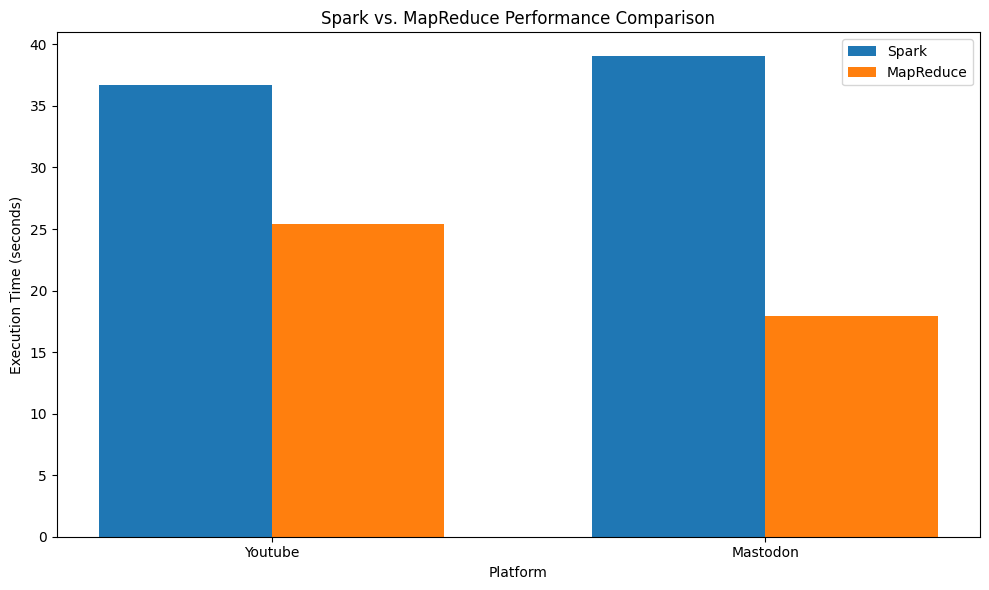

In [57]:
# Visualize performance comparison
plt.figure(figsize=(10, 6))
platforms = list(set(list(spark_performance.keys()) + list(mapreduce_results.keys())))

spark_times = []
mr_times = []
x_labels = []

for platform in platforms:
    x_labels.append(platform.capitalize())

    if platform in spark_performance:
        spark_times.append(spark_performance[platform]['execution_time'])
    else:
        spark_times.append(0)

    if platform in mapreduce_results:
        mr_times.append(mapreduce_results[platform]['execution_time'])
    else:
        mr_times.append(0)

x = np.arange(len(platforms))
width = 0.35

plt.bar(x - width/2, spark_times, width, label='Spark')
plt.bar(x + width/2, mr_times, width, label='MapReduce')

plt.xlabel('Platform')
plt.ylabel('Execution Time (seconds)')
plt.title('Spark vs. MapReduce Performance Comparison')
plt.xticks(x, x_labels)
plt.legend()

plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/performance_comparison.png")
plt.show()

In [58]:
## Cleanup and Close Connections

# Close MongoDB connection
if mongo_client:
    mongo_client.close()
    print("Closed MongoDB connection.")

# Stop Spark session
spark.stop()
print("Stopped Spark session.")

print("\nBatch Layer processing completed successfully!")

Closed MongoDB connection.
Stopped Spark session.

Batch Layer processing completed successfully!
